# 03. Neural Network Classification with PyTorch

Classification is a problem of predicting whether something is one thing or another.

## 1. Make classification data and get it ready

In [1]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                   noise=0.03,
                   random_state=42)

In [2]:
len(X), len(y)

(1000, 1000)

In [3]:
print(f"First 5 samples of X:\n {X[:5]}")
print(f"First 5 samples of y:\n {y[:5]}")

First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
 [1 1 1 1 0]


In [4]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y})

circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


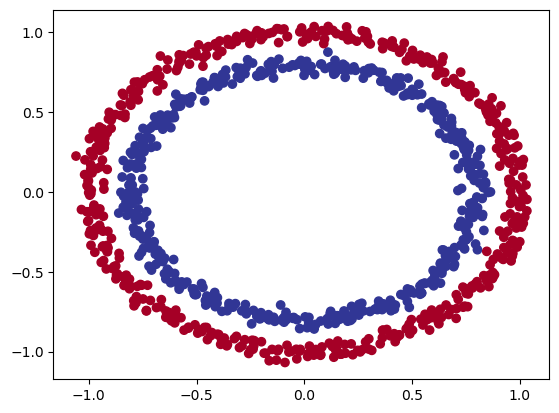

In [5]:
# Visualize, visualize, visualize
import matplotlib.pyplot as plt

plt.scatter(data=circles,
           x="X1",
           y="X2",
           c="label",
           cmap=plt.cm.RdYlBu);

Note: The data we're working with is often referred to as a toy dataset, a dataset that is small enough to experiment but still sizeable enough to practice the concepts.

### 1.1 Check input and output shapes

In [6]:
X.shape, y.shape

((1000, 2), (1000,))

In [7]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shape for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shape for one sample of X: (2,) and the same for y: ()


### 1.2 Turn data into tensors and create train test splits

In [8]:
import torch
torch.__version__

'1.13.1'

In [9]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [10]:
type(X), type(y)

(torch.Tensor, torch.Tensor)

In [11]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size=0.2,
                                                   random_state=42) 

In [12]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model

Let's build a model to classify our blue and red dots.

To do so, we want to:
1. Setup device agnostic code so our code will run on GPU
2. Construct a model (by subsclassing `nn.Module`)
3. Define loss function and optimizer
4. Create training and testing loop

In [13]:
# Import PyTorch and nn
import torch 
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Now we've setup device agnostic code, let's create a model that:
    
1. Subclass `nn.Module` (almost all models in PyTorch subclass it)
2. Create 2 `nn.Linear()` layers that are capable of handling the shapes of our data
3. Define a `forward()` method that outlines the forward pass (forward computation)
4. Instantiate an instance of our model class and send it to the target device

In [14]:
X_train.shape

torch.Size([800, 2])

In [15]:
# 1. Construct a model that subclass nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        
        # 2. Create 2 nn.Linear layer capable of handling the shapes of data
        self.layer_1 = nn.Linear(in_features=2,    # one sample of x has 2 element
                                out_features=5)    # upscales them to 5 features (random num)
        self.layer_2 = nn.Linear(in_features=5,    # matching the output feature of previous layer
                                out_features=1)    # same shape as y, single feature
    
    
    # 3. define a forward() method
    def forward(self, x):
        return self.layer_2(self.layer_1(x))  # x -> layer_1 -> layer_2 -> output
    

# 4. Instantiate an instance of our model class and send it to the target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [16]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [17]:
# Let's replicate the model above using nn.Sequential()

model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [18]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.1214, -0.1463],
                      [-0.4485,  0.3176],
                      [ 0.2590, -0.5383],
                      [ 0.4733,  0.6395],
                      [-0.5447,  0.1466]], device='cuda:0')),
             ('0.bias',
              tensor([-0.1191,  0.2401, -0.4566,  0.3545,  0.3881], device='cuda:0')),
             ('1.weight',
              tensor([[-0.3413,  0.2238, -0.3436,  0.3406, -0.2518]], device='cuda:0')),
             ('1.bias', tensor([0.2161], device='cuda:0'))])

In [19]:
# Make predictions

with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
print(f"Length of Predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test smaple: {len(X_test)}, Shape:{X_test.shape})")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 Labels:\n{y_test[:10]}")

Length of Predictions: 200, Shape: torch.Size([200, 1])
Length of test smaple: 200, Shape:torch.Size([200, 2]))

First 10 predictions:
tensor([[0.7974],
        [0.9588],
        [0.2897],
        [0.9416],
        [0.1554],
        [0.2550],
        [0.8159],
        [0.6508],
        [0.2961],
        [0.9681]], device='cuda:0')

First 10 Labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [20]:
X_test[:10], y_test[:10]

(tensor([[-0.3752,  0.6827],
         [ 0.0154,  0.9600],
         [-0.7028, -0.3147],
         [-0.2853,  0.9664],
         [ 0.4024, -0.7438],
         [ 0.6323, -0.5711],
         [ 0.8561,  0.5499],
         [ 1.0034,  0.1903],
         [-0.7489, -0.2951],
         [ 0.0538,  0.9739]]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

### 2.1 Setup loss function and optimizer

Which loss function or optimizer should you use?

Again... this is problem specific.

Eg. For regression we want MAE or MSE.
For classficiation we want Binary Cross entropy or categorical cross entropy.

As a reminder, loss functions measures how wrong our predictions are.

And for optimizers, two of the most common and useful are SGD and Adam, however PyTorch has many built-in options.

* For the loss function we're going to use `torch.nn.BCEWithLogitsLoss()` as it gives numerical stability as compared to `torch.nn.BCELoss()`

In [21]:
# Setup the loss functions

# loss_fn = nn.BCELoss()  # Required inputs to have gone through sigmoud activation function prior to input to BCELoss
loss_fn = nn.BCEWithLogitsLoss()  # It has inbuilt sigmoid activation function

optimizer = torch.optim.SGD(params=model_0.parameters(),
                           lr=0.1)

In [22]:
# Calculate accuracy - out of 100 examples what %age does our model get right

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

## 3. Train Model

To train our model, we're going to build a training loop with following steps:

* Forward Pass
* Calculate Loss
* Optimizer Zero Grad
* Loss Backward  (backpropagation)
* Optimizer Step (gradient descent)

### 3.1 Going from raw logits -> prediction probabilites -> prediction labels

Our model outputs are going to be raw **logits**. Logit =  raw output of model wihtout being passed to activation fn.

We can convert these **logits** into **prediction probabilities** by passing them to some kind of activation function eg. Sigmoid, Softmax etc.

Then we can convert our model's prediction probabilities to prediction labels by either rounding them or taking the `argmax()`.

In [23]:
# View the first 5 outputs of the forward pass on the test data

model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[0.7974],
        [0.9588],
        [0.2897],
        [0.9416],
        [0.1554]], device='cuda:0')

In [24]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [25]:
# use the sigmoid activation function on our model logits to turn them into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.6894],
        [0.7229],
        [0.5719],
        [0.7194],
        [0.5388]], device='cuda:0')

For our prediction probability values, we need to perform a range-style rounding on them:
* `y_pred_probs` >= 0.5, `y=1` (class 1)
* `y_pred_probs` < 0.5, `y=0` (class 0)

In [26]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# In Full (logits -> pred probs -> pred labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of exta dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([1., 1., 1., 1., 1.], device='cuda:0')

In [27]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

### 3.2 Building a training and testing loop

In [28]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device) , y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Building training and testing loop
for epoch in range(epochs):
    ### Trianing
    model_0.train()
    
    # 1. Forward pass()
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))  #turn logits -> pred probs -> pred labels
    
    # 2. Calculate loss/accuracy
#     loss = loss_fn(torch.sigmoid(y_logits),   # If it was nn.BCELoss()
#                   y_train)
    loss = loss_fn(y_logits,    # Using logits coz our loss is nn.BCEWithLogits which includes sigmoid
                  y_train)
    acc = accuracy_fn(y_true=y_train,
                     y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()
    
    # 4. Loss Backward
    loss.backward()
    
    # 5. Optimizer Step  (Gradient Descent)
    optimizer.step()
    
    ### Testing
    model_0.eval()
    with torch.inference_mode():
        
        # 1. Forward pass
        testing_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(testing_logits))
        
        # 2. Calculate the test loss/accuracy
        test_loss = loss_fn(testing_logits,
                           y_test)
        test_acc = accuracy_fn(y_true=y_test,
                              y_pred=test_pred)
        
    # Print out what's happening
    if epoch % 10 ==0:
        print(f"Epoch: {epoch} | Loss: {loss: .5f} | Acc: {acc:.2f}% | Test Loss: {test_loss: .5f} | Test acc: {test_acc: .2f}%\n")
        

Epoch: 0 | Loss:  0.73070 | Acc: 52.25% | Test Loss:  0.74553 | Test acc:  51.50%

Epoch: 10 | Loss:  0.70860 | Acc: 55.62% | Test Loss:  0.72105 | Test acc:  52.50%

Epoch: 20 | Loss:  0.70032 | Acc: 53.12% | Test Loss:  0.71091 | Test acc:  50.00%

Epoch: 30 | Loss:  0.69700 | Acc: 52.62% | Test Loss:  0.70620 | Test acc:  47.00%

Epoch: 40 | Loss:  0.69554 | Acc: 51.50% | Test Loss:  0.70371 | Test acc:  47.50%

Epoch: 50 | Loss:  0.69481 | Acc: 51.50% | Test Loss:  0.70218 | Test acc:  47.00%

Epoch: 60 | Loss:  0.69440 | Acc: 51.88% | Test Loss:  0.70113 | Test acc:  46.00%

Epoch: 70 | Loss:  0.69412 | Acc: 51.38% | Test Loss:  0.70033 | Test acc:  45.50%

Epoch: 80 | Loss:  0.69392 | Acc: 51.00% | Test Loss:  0.69969 | Test acc:  45.50%

Epoch: 90 | Loss:  0.69376 | Acc: 50.75% | Test Loss:  0.69915 | Test acc:  46.00%



## 4. Make Prediction and evaluate the model

From the metrics it looks like our model isn't leanriung anything....

To inspect it let's make some predictiona nd them visual!

We are going to import a function called `plot_decision_boundary()` -> https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py

In [29]:
# there is a helper function for visualization in a file in github repo
# We are writing code here to get that file and get hands on function

import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo of Daniel Bourke (if it;s not already downloaded)
if Path("helper_functions.py").is_file():
    print("Helper_function.py already exist, skipping download")
else:
    print("Download helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

Helper_function.py already exist, skipping download


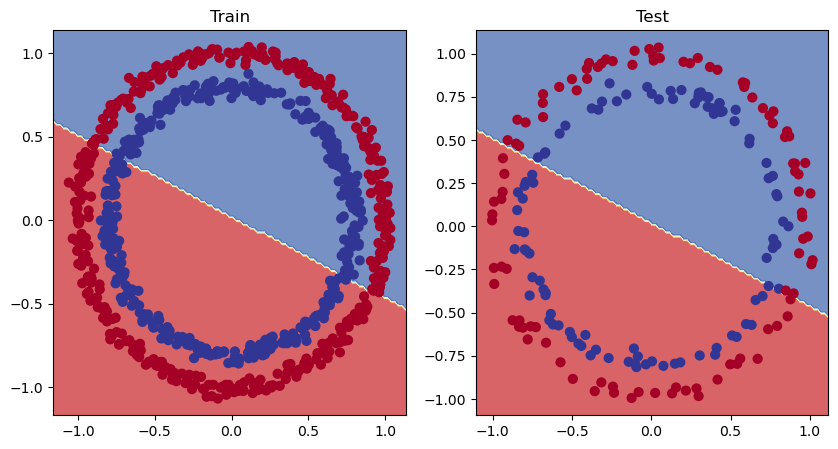

In [30]:
# Plot decision boundary of the model
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

> **Now we can see why we got poor accuracy. We are using Linear functions so it can't work on circular data**

## 5. Improving a model (from a model perspective)

* Add more layers - give the model more chances to learn about pattern in data.
* Add more hidden units - go from 5 hiden units to 10 hidden units
* Fit for longer
* Change in activation functions
* Change the learning rate
* Change the loss function

These options are all from a model's perspective because they deal directly with the model, rather than the data.

Because these options are all values we (as Data Scientist) can change, they are referred to as Hyperparameters.

Let's try and improve model by:
* Adding more hidden units: 5 -> 10
* Increase the number of layer: 2 -> 3
* Increase the number of epochs: 100 -> 1000

<img src="Classification-1.png">

In [31]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        
    def forward(self, x):
#         z = self.layer_1(x)
#         z = self.layer_2(z)
#         z = self.layer_3(z)
        return self.layer_3(self.layer_2(self.layer_1(x))) # This way of writing operations leverages speedups

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [32]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                           lr=0.1)

In [33]:
# Writing a trianing and evaluation loop for model_1

torch.manual_seed(42)
torch.cuda.manual_seed(42)

#Put data on the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Train for longer
epochs = 1000

for epoch in range(epochs):
    ### Training
    model_1.train()
    
    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> pred prob -> pred label
    
    # 2. Calculate the loss/acc
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train,
                     y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()
    
    # 4. Loss backward
    loss.backward()
    
    # 5. optimizer step
    optimizer.step()
    
    
    ### TEsting
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        
        # 2. Calculate loss
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test,
                              y_pred=test_pred)
        
    # Print out whats happening
    if epoch %100 ==0:
        print(f"Epoch : {epoch}, Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")
        

Epoch : 0, Loss: 0.69396, Acc: 50.88% | Test Loss: 0.69261, Test acc: 51.00%
Epoch : 100, Loss: 0.69305, Acc: 50.38% | Test Loss: 0.69379, Test acc: 48.00%
Epoch : 200, Loss: 0.69299, Acc: 51.12% | Test Loss: 0.69437, Test acc: 46.00%
Epoch : 300, Loss: 0.69298, Acc: 51.62% | Test Loss: 0.69458, Test acc: 45.00%
Epoch : 400, Loss: 0.69298, Acc: 51.12% | Test Loss: 0.69465, Test acc: 46.00%
Epoch : 500, Loss: 0.69298, Acc: 51.00% | Test Loss: 0.69467, Test acc: 46.00%
Epoch : 600, Loss: 0.69298, Acc: 51.00% | Test Loss: 0.69468, Test acc: 46.00%
Epoch : 700, Loss: 0.69298, Acc: 51.00% | Test Loss: 0.69468, Test acc: 46.00%
Epoch : 800, Loss: 0.69298, Acc: 51.00% | Test Loss: 0.69468, Test acc: 46.00%
Epoch : 900, Loss: 0.69298, Acc: 51.00% | Test Loss: 0.69468, Test acc: 46.00%


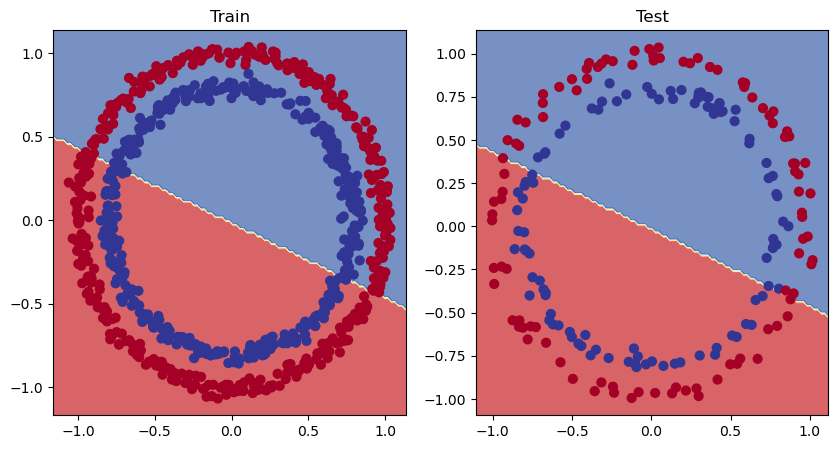

In [34]:
# Plot decision boundary of the model
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### 5.1 Preparing data to see if our model can fit a straight line

One way to troubleshoot to a larger problem is to test out a smaller problem.

In [35]:
# Create some data (same as previous notebook)

weight = 0.7
bias = 0.3

start = 0
end=1
step=0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [36]:
# Create train and test splits

train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the lenghts of each
len(X_train_regression), len(y_train_regression), len(y_test_regression), len(X_test_regression)

(80, 80, 20, 20)

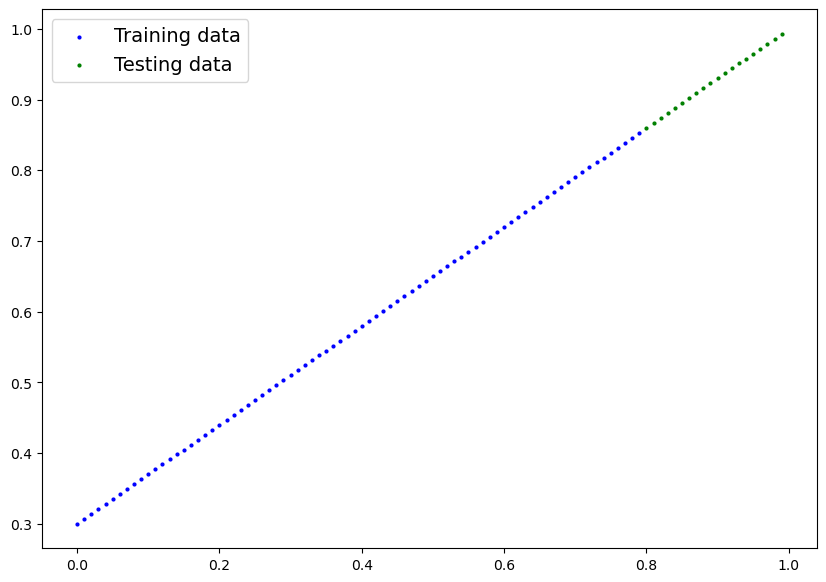

In [37]:
plot_predictions(train_data=X_train_regression,
                train_labels=y_train_regression,
                test_data=X_test_regression,
                test_labels=y_test_regression);

### 5.2 Adjust `model_1` to fit a straight line

In [38]:
# Same architecture as model_1 (by using nn.sequential)

model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [39]:
# Loss and optimizer
loss_fn = nn.L1Loss()

# Optimizer
optimizer = torch.optim.SGD(params=model_2.parameters(),
                           lr=0.01)

In [40]:
# Train the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the epochs
epochs = 1000

# Put the data on the target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

# Training
for epoch in range(epochs):
    y_pred = model_2(X_train_regression)
    loss = loss_fn(y_pred, y_train_regression)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Testing
    model_2.eval()
    with torch.inference_mode():
        test_pred = model_2(X_test_regression)
        test_loss = loss_fn(test_pred, y_test_regression)
        
    # Print our whats happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test Loss: {test_loss:.5f}")

Epoch: 0 | Loss: 0.75986 | Test Loss: 0.91103
Epoch: 100 | Loss: 0.02858 | Test Loss: 0.00081
Epoch: 200 | Loss: 0.02533 | Test Loss: 0.00209
Epoch: 300 | Loss: 0.02137 | Test Loss: 0.00305
Epoch: 400 | Loss: 0.01964 | Test Loss: 0.00341
Epoch: 500 | Loss: 0.01940 | Test Loss: 0.00387
Epoch: 600 | Loss: 0.01903 | Test Loss: 0.00379
Epoch: 700 | Loss: 0.01878 | Test Loss: 0.00381
Epoch: 800 | Loss: 0.01840 | Test Loss: 0.00329
Epoch: 900 | Loss: 0.01798 | Test Loss: 0.00360


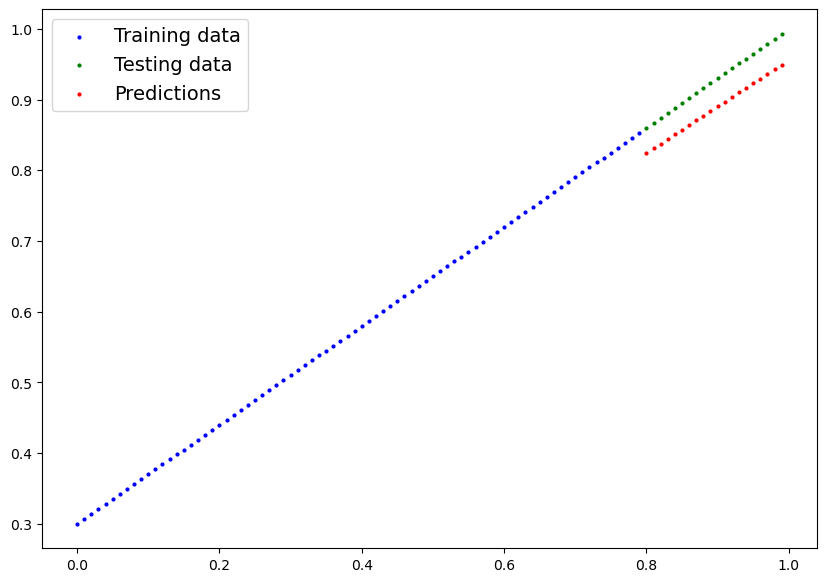

In [41]:
# Turn on evaluation mode
model_2.eval()

# Make prediction (inference)
with torch.inference_mode():
    y_preds = model_2(X_test_regression)

# plot data and predictions
plot_predictions(train_data=X_train_regression.cpu(),
                train_labels=y_train_regression.cpu(),
                test_data=X_test_regression.cpu(),
                test_labels=y_test_regression.cpu(),
                predictions=y_preds.cpu())

## 6. The missing piece: Non-linearity

"What patterns could you draw if you were given an infinite amound of a strighjt and non-stright lines?"

or in machine learning terms, an infinite (but really its finite) or linear and non-linear functions?

### 6.1 Recreating non-linear data (red and blue circles)

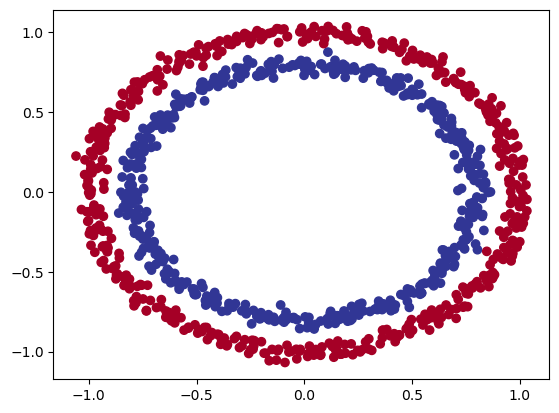

In [42]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                   noise=0.03,
                   random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);

In [43]:
# Convert data to tensors and then to train and test splits
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                   random_state=42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### 6.2 Building a model with non-linearity

* Linear = straight lines
* non-Linear = non-straight 

ANN are a large combination of linear and non-linear functiosn which are potentially able to find patterns in data.

In [44]:
# Build a model with non-linear activation functions
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()   # non linear activation fn
        
    def forward(self, x):
        # Where should we pur our non-Linear acttivation functions?
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
    
model_3 = CircleModelV2().to(device)

model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [45]:
# Loss Function
loss_fn = nn.BCEWithLogitsLoss()

# optimizer
optimizer = torch.optim.SGD(params=model_3.parameters(),
                           lr=0.1)

In [46]:
# Training and testing loop

torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Put data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Loop through data
epochs = 1000

for epoch in range(epochs):
    ### Trianing
    model_3.train()
    
    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    
    # Calculate the loss
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    
    # 3. optimizer zero grad
    optimizer.zero_grad()
    
    # 4. loss backward
    loss.backward()
    
    # 5. step the optimizer
    optimizer.step()
    
    ### Testing
    model_3.eval()
    with torch.inference_mode():
        #forward pass
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test,
                              y_pred=test_pred)
        
    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch}| Loss: {loss:.4f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

Epoch: 0| Loss: 0.6929, Acc: 50.00% | Test Loss: 0.6932, Test Acc: 50.00%
Epoch: 100| Loss: 0.6912, Acc: 52.88% | Test Loss: 0.6910, Test Acc: 52.50%
Epoch: 200| Loss: 0.6898, Acc: 53.37% | Test Loss: 0.6894, Test Acc: 55.00%
Epoch: 300| Loss: 0.6879, Acc: 53.00% | Test Loss: 0.6872, Test Acc: 56.00%
Epoch: 400| Loss: 0.6852, Acc: 52.75% | Test Loss: 0.6841, Test Acc: 56.50%
Epoch: 500| Loss: 0.6810, Acc: 52.75% | Test Loss: 0.6794, Test Acc: 56.50%
Epoch: 600| Loss: 0.6751, Acc: 54.50% | Test Loss: 0.6729, Test Acc: 56.00%
Epoch: 700| Loss: 0.6666, Acc: 58.38% | Test Loss: 0.6632, Test Acc: 59.00%
Epoch: 800| Loss: 0.6516, Acc: 64.00% | Test Loss: 0.6476, Test Acc: 67.50%
Epoch: 900| Loss: 0.6236, Acc: 74.00% | Test Loss: 0.6215, Test Acc: 79.00%


### 6.4 Evaluating a model trained with non-linear activation function

In [47]:
# Makes predictions
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()

y_preds[:5], y_test[:5]

(tensor([1., 0., 1., 0., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1.], device='cuda:0'))

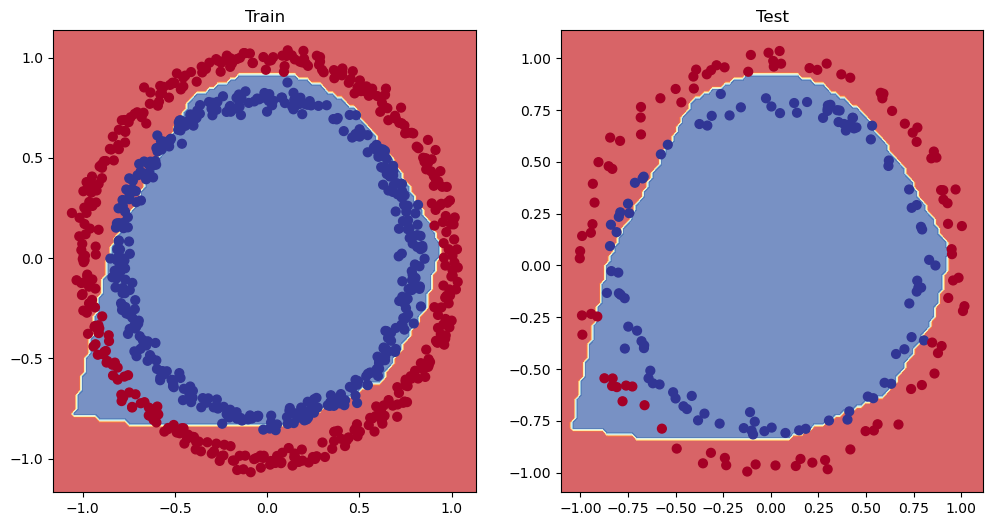

In [48]:
# Plot decision boundaries
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

## 7. Replicating non-linear activation functions

Neural network, rather than us telling the model what to learn, we give it the tools to discover patterns in data and triues to figure pattersn on its own.

And these tools are linear and non linear functions.

In [49]:
# Create a tensor
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A.dtype

torch.float32

In [50]:
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

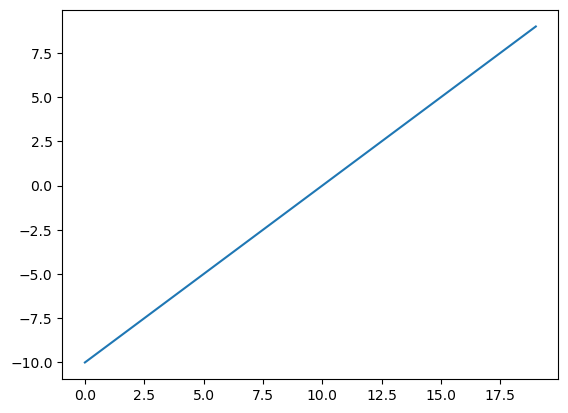

In [51]:
# Visualize the tensor
plt.plot(A);

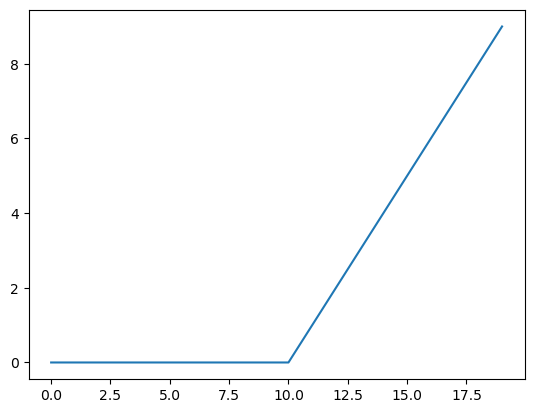

In [52]:
plt.plot(torch.relu(A))

In [53]:
def relu(x: torch.Tensor) -> torch.Tensor:
    return torch.maximum(torch.tensor(0), x) # inputs must be tensors
    
relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

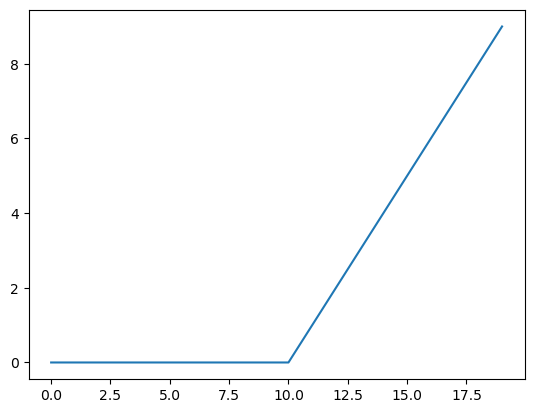

In [54]:
# Plot ReLU actication function

plt.plot(relu(A))

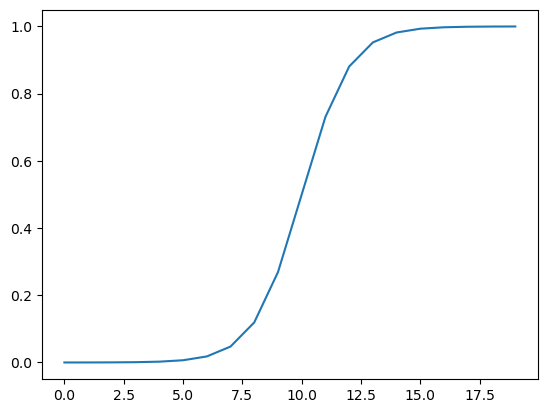

In [55]:
# Now let's do the same for sigmoid

def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

plt.plot(sigmoid(A))

## 8. Putting it all together with a multi-class classification problem

* Binary classification = one thing or another (cat vs dog , spam or not spam)
* Multi-class classification = more than one thing or another (cat vs dog vs chicken)

### 8.1 Creating a toy multi-class dataset


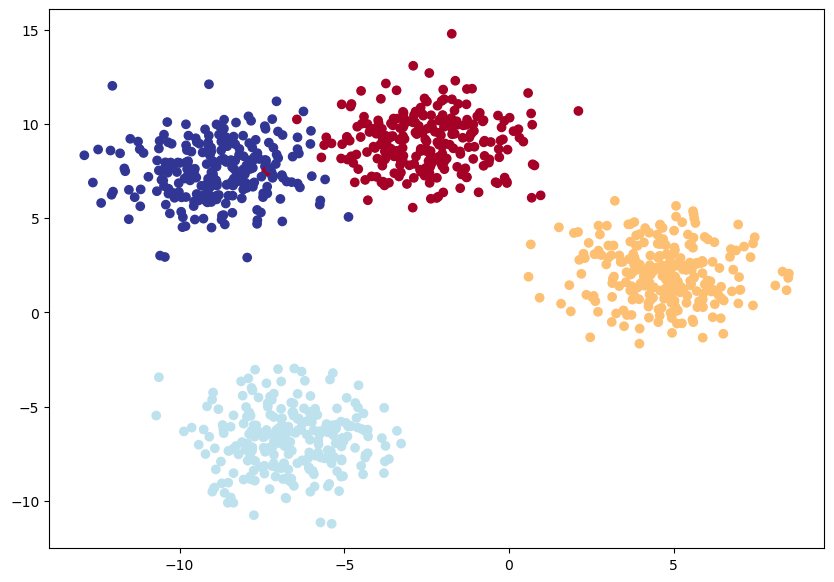

In [56]:
# Import dependencies
import torch 
from torch import nn
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                           n_features=NUM_FEATURES,
                           centers=NUM_CLASSES,
                           cluster_std=1.5,     # give the clusters a little shake up
                           random_state=RANDOM_SEED)

# 2. turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Split into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                       y_blob,
                                                                       test_size=0.2,
                                                                       random_state=RANDOM_SEED)

# 4. Plot Data (VISUALIZE!!)
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

### 8.2 Building a multi-class classification model in PyTorch

In [57]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [58]:
# Build a multi-class classification model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """ Initializes multi-class classification model.
        
        Args:
          input_features(int): Number of input features to the model
          outpu_features(int): Number of output features (number of output classes)
          hidden_units(int): Number of hidden units between layers, default 8
          
        Returns:
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )
        
    def forward(self, x):
        return self.linear_layer_stack(x)
    
    
# Create an instance of Blocb model and set to target device
model_4 = BlobModel(input_features=2,
                   output_features=4,
                   hidden_units=8).to(device)

model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

### 8.3 Create a loss function and an optimizer for a multi-class classification model

In [59]:
# Loss function for multi-class classification
loss_fn = nn.CrossEntropyLoss()

# Optimizer for multi-class classification  - updates our model parameters to try and reduce the loss
optimizer = torch.optim.SGD(params=model_4.parameters(),
                           lr=0.1)

### 8.4 Getting prediction probabilites for a multi-class PyTorch model

In order to evaluate and traing and test our model, we need to convert our model's outputs (logits) to prediction probabilities and then to prediciton labels.

Logits (raw output of the model) **->** Prediction Prob (use `torch.softmax()`) **->** pred Labels (takes the `argmax` of the prediction probabilites.

In [60]:
# Let's get some raw outputs of our model (logits)
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test.to(device))
    
y_logits[:5]

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]], device='cuda:0')

In [61]:
y_blob_test[:5]

tensor([1, 3, 2, 1, 0])

In [62]:
# Convert our model's output logits to prediction probabilities

y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]], device='cuda:0')
tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]], device='cuda:0')


In [63]:
# Convert our model's pred prob output to prediction labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')

In [64]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

### 8.5 Creating a training loop and testing loop for multi-class PyTorch Model

In [65]:
# Fit the multi-class model to the data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Putting out inputs to the device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

# Setting number of epochs
epochs = 100

for epoch in range(epochs):
    ### Training 
    model_4.train()
    
    # 1. Forward Pass
    y_logits = model_4(X_blob_train)
    y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)
    
    # 2. Calculate the loss/acc
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train,
                     y_pred=y_preds)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()
    
    # 4. Loss Backwards
    loss.backward()
    
    # 5. optimizer step
    optimizer.step()
    
    ### Testing
    model_4.eval()
    with torch.inference_mode():
        # Forward pass
        test_logits = model_4(X_blob_test)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)
        
        # Calculate the loss
        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test,
                              y_pred=test_preds)
        
    # Print out whats happening
    if epoch %10 ==0:
        print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.4f}, Test Acc:{test_acc:.2f}%")

Epoch: 0 | Loss: 1.1588, Acc: 40.38% | Test Loss: 1.0755, Test Acc:48.00%
Epoch: 10 | Loss: 0.6448, Acc: 96.75% | Test Loss: 0.6607, Test Acc:97.50%
Epoch: 20 | Loss: 0.4254, Acc: 98.50% | Test Loss: 0.4307, Test Acc:100.00%
Epoch: 30 | Loss: 0.2529, Acc: 99.12% | Test Loss: 0.2451, Test Acc:99.50%
Epoch: 40 | Loss: 0.1123, Acc: 99.25% | Test Loss: 0.1023, Test Acc:99.50%
Epoch: 50 | Loss: 0.0663, Acc: 99.25% | Test Loss: 0.0585, Test Acc:99.50%
Epoch: 60 | Loss: 0.0507, Acc: 99.25% | Test Loss: 0.0429, Test Acc:99.50%
Epoch: 70 | Loss: 0.0430, Acc: 99.25% | Test Loss: 0.0349, Test Acc:99.50%
Epoch: 80 | Loss: 0.0384, Acc: 99.25% | Test Loss: 0.0299, Test Acc:99.50%
Epoch: 90 | Loss: 0.0352, Acc: 99.25% | Test Loss: 0.0266, Test Acc:99.50%


### 8.6 Making and evaluating predictions with a PyTorch multi-class model

In [68]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)
    
# View the first 10 predictions
y_logits[:10]

tensor([[-0.6249,  5.9860, -7.6323, -8.4470],
        [-2.1738, -6.3750, -3.7202,  3.1203],
        [-3.4102, -3.8958,  3.1567, -2.6119],
        [-1.1505,  4.1962, -3.8472, -4.8820],
        [ 3.7548, -1.3391, -9.1422, -6.9466],
        [-2.8211, -7.5767, -4.2944,  3.7944],
        [-3.0306, -3.3328,  2.7955, -2.1374],
        [ 3.3761, -4.0375, -6.8987, -3.5503],
        [-4.3620, -4.9904,  3.8123, -3.3814],
        [ 3.5012, -3.0281, -7.5401, -4.7064]], device='cuda:0')

In [69]:
# Going from Logits -> Prediction probs
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([[1.3438e-03, 9.9865e-01, 1.2164e-06, 5.3854e-07],
        [4.9905e-03, 7.4740e-05, 1.0630e-03, 9.9387e-01],
        [1.3985e-03, 8.6060e-04, 9.9463e-01, 3.1073e-03],
        [4.7389e-03, 9.9483e-01, 3.1956e-04, 1.1353e-04],
        [9.9388e-01, 6.0966e-03, 2.4904e-06, 2.2378e-05],
        [1.3372e-03, 1.1504e-05, 3.0644e-04, 9.9834e-01],
        [2.9138e-03, 2.1537e-03, 9.8781e-01, 7.1181e-03],
        [9.9838e-01, 6.0198e-04, 3.4435e-05, 9.7989e-04],
        [2.8147e-04, 1.5016e-04, 9.9882e-01, 7.5044e-04],
        [9.9825e-01, 1.4575e-03, 1.5998e-05, 2.7210e-04]], device='cuda:0')

In [70]:
# Going from pred prob -> pred labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')

In [71]:
y_blob_test[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')

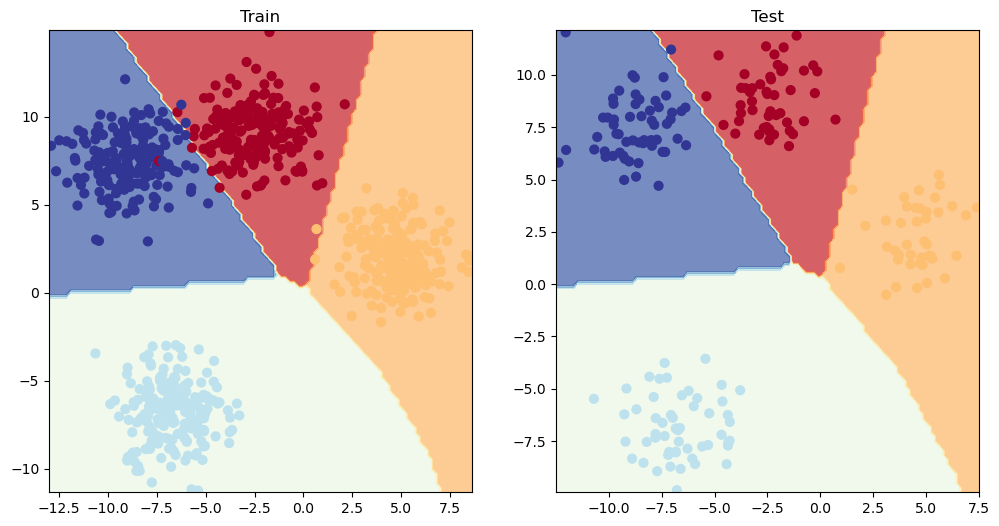

In [72]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

## 9. A Few more classification metrics ... (to evaluate our classification model)

* Accuracy - Out of 100 samples, how many of them our model get right
* Precision
* Recall
* F1-score
* Confusion Matrix
* Classification Report

TorchMetrics - https://torchmetrics.readthedocs.io/en/latest/all-metrics.html

In [75]:
import torchmetrics

# Setup metric
torchmetric_accuracy = torchmetrics.Accuracy(task='multiclass',num_classes=4).to(device)

# Calculate accuracy
torchmetric_accuracy(y_preds, y_blob_test)

tensor(0.9950, device='cuda:0')

In [78]:
# Setup metric
torchmetric_conf_mat = torchmetrics.ConfusionMatrix(task="multiclass",
                                                   num_classes=4).to(device)

# Calculate
torchmetric_conf_mat(y_preds, y_blob_test)

tensor([[49,  0,  0,  0],
        [ 0, 41,  0,  0],
        [ 0,  0, 53,  0],
        [ 1,  0,  0, 56]], device='cuda:0')

----

# Exercises

https://www.learnpytorch.io/02_pytorch_classification/#exercises

---